# chatbot

In [7]:
import os
import re
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

<br><br><br><br>

# 1. 데이터 로드

$ wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv

In [27]:
dataset_file_path = os.getenv('HOME') + '/aiffel/chatbot/ChatbotData.csv'

<br><br><br><br>

# 2. 데이터 전처리
1. 질문과 답변의 쌍을 추출
2. 문장에서 단어와 구두점 사이에 공백 추가

* 숫자도 빼는 것이 좋은지 확인해보기

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 영어 포함 시 소문자 변환, 양쪽 공백 제거
    sentence = sentence.lower().strip()
    
    # 단어와 구두점 사이 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글, 알파벳, .,?!을 제외한 문자 공백으로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

### 데이터 로드 및 전처리

In [25]:
def load_conversations():
    with open(dataset_file_path, errors='ignore') as file:
        lines = file.readlines()
        
    inputs, outputs = [], []
    with open(dataset_file_path) as file:
        lines = csv.reader(file)
        next(lines)
        for line in lines:
            inputs.append(preprocess_sentence(line[0]))
            outputs.append(preprocess_sentence(line[1]))
    return inputs, outputs

In [26]:
questions, answers = load_conversations()

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print()
print('전처리 후의 11번째 질문 샘플: {}'.format(questions[11]))
print('전처리 후의 11번째 답변 샘플: {}'.format(answers[11]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823

전처리 후의 11번째 질문 샘플: 가끔 궁금해
전처리 후의 11번째 답변 샘플: 그 사람도 그럴 거예요 .


### 토크나이징  
단어장(Vocabulary) 만들기 - SubwordTextEncoder 이용

In [28]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [33]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


- 단어장의 크기 : 8133개 (0-8132)  
- 전체 단어장 크기 : 8135개

In [34]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


### 정수 인코딩 & 패딩 & start, end token 추가
- tokenizer.encode() : 단어 > 정수
- tokenizer.decode() : 정수 > 단어

In [39]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9391017508246637
answers 최대 길이 : 24
answers 평균 길이 : 4.716146494121627


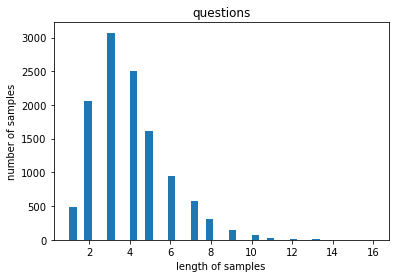

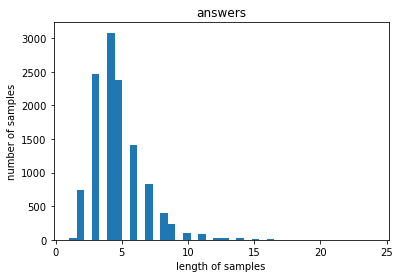

In [37]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
# 최대 허용 길이 지정
MAX_LENGTH = 10

# 정수인코딩, 최대길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작, 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이 10으로 모든 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs

In [43]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 9128
필터링 후의 답변 샘플 개수: 9128


### 교사 강요(Teacher Forcing) 사용하기

In [44]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [45]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 10), dec_inputs: (None, 9)}, {outputs: (None, 9)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

<br><br><br><br>

# 3. 모델 구성

## positional encoding
같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, 같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있다.

In [46]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Scaled Dot Product Attention
내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구함

- attention : 단어들 간의 유사도를 구하는 매커니즘

In [47]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)  # # tf.matmul : 두 텐서를 행렬곱한 결과 텐서를 리턴

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

## Multi Head Attention
- 내부적으로는 스케일드 닷 프로덕트 어테션 함수를 호출

In [48]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Masking
특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

### Padding Masking
문자의 길이를 맞추기 위해서 패딩을 넣어 처리해준 부분은 실제 의미가 있는 단어가 아니므로 패딩부분을 마스킹하여 가려준다.

In [49]:
# 0인 위치에서 숫자 1이 나오고, 숫자0이 아닌 위치는 숫자0이 나오게 하는 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### Look-ahead Masking 다음 단어 가리기
RNN은 각 step마다 순서대로 들어가는 반면, 트랜스포머는 문장행렬을 만들어 한 번에 행렬형태로 입력으로 들어가기 때문에 마스킹을 한다.

In [50]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## 인코더
- 하나의 인코더 층은 2개의 서브 층으로 나뉜다.
  - 셀프어텐션(멀티 헤드 어텐션)
  - 피드 포워드 신경망

In [51]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [52]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 디코더
- 셀프 어텐션
- 인코더-디코더 어텐션 : query가 디코더의 벡터, key-value가 인코더의 벡터
- 피드 포워드 신경망

In [53]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

In [54]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

## 모델 정의 및 훈련

In [55]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='enc_padding_mask'
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='dec_padding_mask'
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


## 모델생성

In [81]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 512)    7321088     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실함수
레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [57]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 커스텀된 학습률 learning rate
Custom Learning rate Scheduling

In [58]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

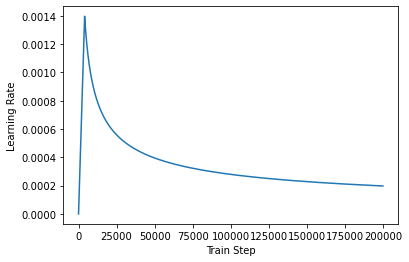

In [83]:
# 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [82]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 훈련

In [84]:
EPOCHS = 40
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
143/143 [==============================] - 9s 63ms/step - loss: 5.2159 - accuracy: 0.1267
Epoch 2/40
143/143 [==============================] - 9s 63ms/step - loss: 4.0647 - accuracy: 0.2138
Epoch 3/40
143/143 [==============================] - 9s 63ms/step - loss: 3.5820 - accuracy: 0.2191
Epoch 4/40
143/143 [==============================] - 9s 62ms/step - loss: 3.3440 - accuracy: 0.2303
Epoch 5/40
143/143 [==============================] - 9s 63ms/step - loss: 3.1263 - accuracy: 0.2416
Epoch 6/40
143/143 [==============================] - 9s 63ms/step - loss: 2.8908 - accuracy: 0.2591
Epoch 7/40
143/143 [==============================] - 9s 62ms/step - loss: 2.6347 - accuracy: 0.2861
Epoch 8/40
143/143 [==============================] - 9s 62ms/step - loss: 2.3532 - accuracy: 0.3205
Epoch 9/40
143/143 [==============================] - 9s 62ms/step - loss: 2.0406 - accuracy: 0.3603
Epoch 10/40
143/143 [==============================] - 9s 63ms/step - loss: 1.7151 - accura

<br><br><br><br>

# 챗봇 테스트
예측(inference) 과정
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [62]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331  86  30  5  1059  7  8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [63]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 함수
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [85]:
sentence_generation('놀러 가고 싶다.')

입력 : 놀러 가고 싶다.
출력 : 갈때 저도 같이 가요 .


'갈때 저도 같이 가요 .'

In [86]:
sentence_generation('몸이 조금 안 좋은 것 같아')

입력 : 몸이 조금 안 좋은 것 같아
출력 : 피로를 풀어야 할 것 같아요 .


'피로를 풀어야 할 것 같아요 .'

In [87]:
sentence_generation('오늘 정말 공부하기 싫다 ㅠㅠ')

입력 : 오늘 정말 공부하기 싫다 ㅠㅠ
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

In [90]:
sentence_generation('오늘 뭐할까')

입력 : 오늘 뭐할까
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

<br><br><br><br>

## 회고
### 이번 프로젝트에서 어려웠던 점
모델 전체적 구조를 이해하기 어려웠다.

### 프로젝트를 진행하면서 알아낸 점
공부하다 트랜스포머가 나오게 된 배경에 대해서 알게 되었다. CNN은 필터가 슬라이딩을 통해 연산하는데 window안에서 local context에 집중하여 문장의 길이가 긴 경우 전체적인 맥락을 잡아내기에는 어려움이 있다. RNN은 이전의 문장들의 특징들을 반영할 수 있는 장점은 있으나 문장이 길어질수록 입력값들의 특징들이 끝까지 반영되기 어려운 단점이 있고, RN은 $x_t$를 제외하고 나머지 요소들을 다 반영하므로 dependency문제가 발생하지는 않으나 각각의 unit마다 연산들을 많이 해야하기 때문에 적용하기에는 무겁다고 한다. 그래서 나온 것이 transformer라고 한다.

### 루브릭 평가 지표를 맞추기 위해 시도한 것들
**기존 하이퍼파라미터**  
- NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수  
- D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원  
- NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수   
- UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기  
- DROPOUT = 0.1  # 드롭아웃 비율  
- epochs = 20

**변경 하이퍼파라미터 및 결과**
1. epoch = 40
  - loss: 0.0174 - accuracy: 0.6623
  - 놀러 가고 싶다. > 저도 데려가 주세요 .
  - 몸이 조금 안 좋은 것 같아 > 운동할 맛 나겠어요 .


2. epoch = 100
  - loss: 0.0046 - accuracy: 0.6642
  - 놀러 가고 싶다. > 저도 데려가 주세요 .
  - 몸이 조금 안 좋은 것 같아 > 피로를 풀어야 할 것 같아요 .
  - 오늘 정말 공부하기 싫다 ㅠㅠ > 잠시 쉬어도 돼요 .


3. epoch = 40 / NUM_LAYERS = 5
  - loss: 0.1021 - accuracy: 0.6393
  - 놀러 가고 싶다. > 주소 알려주세요 .
  - 몸이 조금 안 좋은 것 같아 > 계획대로 되는 건 없어요 .
  - 오늘 정말 공부하기 싫다 ㅠㅠ > 항상 못해본 건 궁금하더라고요 .


4. epoch = 40 / D_MODEL = 512
  - loss: 0.0380 - accuracy: 0.6573
  - 놀러 가고 싶다. > 갈때 저도 같이 가요 .
  - 몸이 조금 안 좋은 것 같아 > 피로를 풀어야 할 것 같아요 .
  - 오늘 정말 공부하기 싫다 ㅠㅠ > 잠시 쉬어도 돼요 .


epoch를 늘리거나 D_MODEL을 늘렸더니 입력 결과가 꽤나 괜찮았다. 정확도는 65정도에서 크게 개선되지 않았다.
  
<br>

### 자기 다짐
모델에 대한 이해도가 아직 부족하다. 조금 더 공부해보고 여러번 따라쳐봐야할 것 같다.